# ช่วงที่ 1 โมเดลตระกูลเส้นตรง
[scikit-learn](https://scikit-learn.org/stable/) library ที่เราจะใช้กันเป็นหลักมีคำอธิบายประกอบภาพชัดเจน แนะนำให้ศึกษาเพิ่มเติมเพื่อทำความรู้จักโมเดลอื่น ๆ ที่เราไม่ได้เรียนกันในคอร์สนี้

สำหรับช่วงนี้เราจะเล่นกับโมเดลตระกูลเส้นตรง เช่น [Linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), [Ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), [LASSO regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), [Logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), [SVM สำหรับ classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), และ [SVM สำหรับ regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) กัน

# การเตรียมข้อมูล
เราจะเชื่อมต่อ Google Colab เข้ากับ Google Drive ด้วยคำสั่งข้างล่าง โดยตำแหน่ง folder จะอยู่ที่ /content/drive/MyDrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ดึง library ต่าง ๆ ที่เราต้องใช้
ใน scikit-learn จะกระจายฟังก์ชันที่ทำหน้าที่ต่าง ๆ ไว้ใน sub-library ย่อย เช่น [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) อยู่ใน sklearn.decomposition

โดยส่วนใหญ่ ชื่อของ sub-library มักจะสื่่อถึงหน้าที่ของฟังก์ชันเหล่านี้อยู่แล้ว แต่สำหรับคนที่เพิ่งจะเริ่มใช้อาจจะต้องใช้เวลาเพื่อทำความคุ้นเคย

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVC, SVR

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix

from scipy.stats import pearsonr, spearmanr, kendalltau

# ข้อมูลชุดที่ 1 ความแข็งแรงของคอนกรีต
อย่าลืมเปลี่ยนตำแหน่งของไฟล์ ConcreteStrength.csv ให้เป็นไปตามตำแหน่งที่เราวางใน Google Drive ของเราเอง

ข้อมูลชุดนี้เกี่ยวกับความแข็งแรงของคอนกรีต ซึ่งขึ้นอยู่กับปัจจัยสองส่วน คือ (1) ส่วนผสม และ (2) อายุ โดยส่วนผสมมีอยู่ 7 องค์ประกอบได้แก่
* Cement
* Blast Furnace Slag
* Fly Ash
* Water
* Superplasticizer
* Coarse Aggregate
* Fine Aggregate

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/ConcreteStrength.csv', index_col = None) ## ข้อมูลนี้ไม่มี row index
data.columns = [x.split('(')[0].strip() for x in data.columns] ## ปรับชื่อคอลัมน์ให้กระชับ
data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


ปริมาณของข้อมูล มี 1030 ตัวอย่าง

In [4]:
print('data shape:', data.shape)

data shape: (1030, 9)


## แยกตัวแปร input กับ output ออกจากกัน
output คือคอลัมน์สุดท้าย ที่เป็นความแข็งแรงของคอนกรีต (Concrete compressive strength)

In [6]:
input_data = data.iloc[:, :-1]
output_data = data.iloc[:, -1]

display(input_data.head(2))
display(output_data.head(2))

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28


0    79.99
1    61.89
Name: Concrete compressive strength, dtype: float64

## ดูความสัมพันธ์ระหว่างข้อมูล input กับ output
รายละเอียดเหล่านี้จะบอกเราคร่าว ๆ ได้ว่าจะสามารถทำนาย output ได้ยากหรือง่ายแค่ไหน

### ดูด้วยตาผ่าน scatter

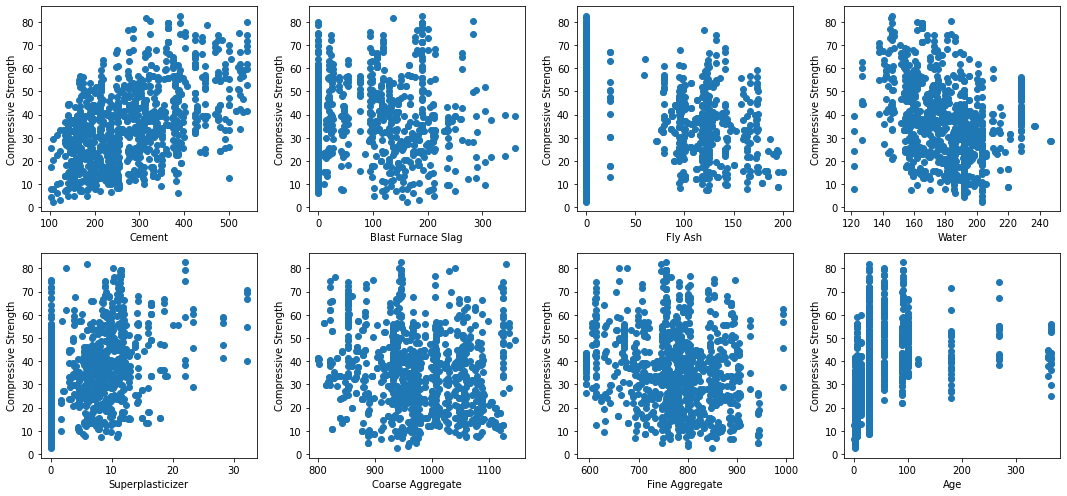

In [7]:
plt.figure(figsize = (15, 7))

for i in range(input_data.shape[1]):
    plt.subplot(2, 4, i + 1)
    plt.scatter(input_data.iloc[:, i], output_data)
    plt.xlabel(input_data.columns[i]); plt.ylabel('Compressive Strength')

plt.tight_layout()
plt.show()

### วัดความสัมพันธ์ด้วย correlation แบบต่าง ๆ
* Pearson's linear correlation
* Spearman's rank correlation
* Kendall's tau

In [8]:
correlations = pd.DataFrame(0, index = input_data.columns, columns = ['Pearson', 'Spearman', 'Kendall'])

for x in input_data.columns:
    correlations.loc[x, :] = [pearsonr(input_data[x], output_data)[0], ## ฟังก์ชันเหล่านี้จะคืนค่า correlation และ p-value 
                              spearmanr(input_data[x], output_data)[0],
                              kendalltau(input_data[x], output_data)[0]]

correlations.head(10)

,Pearson,Spearman,Kendall
Cement,0.497832,0.477614,0.327237
Blast Furnace Slag,0.134829,0.164105,0.119335
Fly Ash,-0.105755,-0.077830,-0.059587
Water,-0.289633,-0.308414,-0.206085
Superplasticizer,0.366079,0.347786,0.249662
Coarse Aggregate,-0.164935,-0.183542,-0.123757
Fine Aggregate,-0.167241,-0.179962,-0.122255
Age,0.328873,0.596028,0.449080


## แบ่งข้อมูลสำหรับพัฒนาโมเดล
สำหรับตอนนี้เราจะยังไม่กำกับเงื่อนไขการแบ่งใด ๆ นอกจากกำหนดสัดส่วนจำนวนข้อมูลเท่านั้น

แบ่ง 20% เป็น test set แล้วที่เหลือนำมาแบ่งเป็น 5-fold cross-validation

In [9]:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size = 0.2, random_state = 4649)

print('train data shape:', X_train.shape)
print('test data shape:', X_test.shape)

train data shape: (824, 8)
test data shape: (206, 8)


### แบ่งข้อมูล training ด้วย 5-fold cross-validation
ใช้ [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) เนื่องจากไม่มีเงื่อนไขใด ๆ

In [10]:
cv_splitter = KFold(n_splits = 5, shuffle = True, random_state = 4649)

for train_indices, test_indices in cv_splitter.split(X_train): ## ทดสอบการแบ่ง
    print('train size:', train_indices.shape, 'test size:', test_indices.shape)

train size: (659,) test size: (165,)
train size: (659,) test size: (165,)
train size: (659,) test size: (165,)
train size: (659,) test size: (165,)
train size: (660,) test size: (164,)


## ทำการ standardize ข้อมูลทั้งหมด
ใช้ mean และ SD จาก training set ในการ standardize test set เพื่อป้องกัน information leak

In [11]:
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train.values.reshape([-1, 1])) ## ฟังก์ชันบางตัวจะจุกจิกนิดหน่อยในเรื่อง 1D หรือ 2D array

X_train_std = pd.DataFrame(X_scaler.transform(X_train), index = X_train.index, columns = X_train.columns) ## เพื่อความสะดวกในตอนวิเคราะห์ผลหลังทำโมเดล
X_test_std = pd.DataFrame(X_scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

y_train_std = y_scaler.transform(y_train.values.reshape([-1, 1]))
y_test_std = y_scaler.transform(y_test.values.reshape([-1, 1]))

In [12]:
X_train_std.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
623,0.239325,-0.857452,-0.821476,0.523296,-1.017372,-0.072157,0.497285,-0.670388
701,0.054765,1.339100,-0.821476,0.476938,-1.017372,-0.540345,-0.687732,0.654713
652,-1.751986,0.892926,-0.821476,0.476938,-1.017372,-1.125579,2.132660,-0.670388
271,-0.491146,-0.857452,1.085292,-0.357490,0.096767,1.077504,0.075862,-0.289612
553,-0.415379,3.254220,-0.821476,0.184888,-1.017372,-0.415494,-1.360752,-0.609463


## ลองเทรนโมเดลแบบ default ดูก่อน
* Linear Regression
* Ridge
* LASSO

ตั้งค่า $\alpha$ = 1.0 เพื่อกำกับขนาดของ regularization

In [13]:
base_linear = LinearRegression()
base_ridge = Ridge(alpha = 1.0, random_state = 4649)
base_lasso = Lasso(alpha = 1.0, random_state = 4649)

base_linear.fit(X_train_std, y_train_std)
base_ridge.fit(X_train_std, y_train_std)
base_lasso.fit(X_train_std, y_train_std)

Lasso(random_state=4649)

### ทำนายค่าบน training set และ test set เพื่อดูว่าตอบได้ดีแค่ไหน

In [14]:
base_linear_pred_train = base_linear.predict(X_train_std)
base_ridge_pred_train = base_ridge.predict(X_train_std)
base_lasso_pred_train = base_lasso.predict(X_train_std)

base_linear_pred_test = base_linear.predict(X_test_std)
base_ridge_pred_test = base_ridge.predict(X_test_std)
base_lasso_pred_test = base_lasso.predict(X_test_std)

### ดูผลจากตัวเลขค่าความคลาดเคลื่อน
ใช้ Mean Absolute Error (MAE)

In [15]:
base_maes = pd.DataFrame(0, index = ['Linear', 'Ridge', 'LASSO'], columns = ['Train', 'Test'])
base_maes.loc['Linear', :] = [mean_absolute_error(y_train_std, base_linear_pred_train), mean_absolute_error(y_test_std, base_linear_pred_test)]
base_maes.loc['Ridge', :] = [mean_absolute_error(y_train_std, base_ridge_pred_train), mean_absolute_error(y_test_std, base_ridge_pred_test)]
base_maes.loc['LASSO', :] = [mean_absolute_error(y_train_std, base_lasso_pred_train), mean_absolute_error(y_test_std, base_lasso_pred_test)]

base_maes.head()

,Train,Test
Linear,0.502314,0.437730
Ridge,0.502637,0.438212
LASSO,0.807704,0.773017


ผลของ LASSO ยังดูแย่ ซึ่งเกิดจากการที่ค่า $\alpha$ = 1.0 ยังไม่เหมาะสม

### ดูผลด้วยตาผ่าน scatter

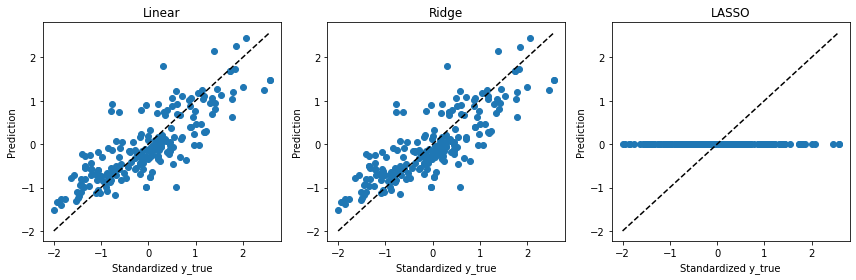

In [16]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 3, 1)
plt.scatter(y_test_std, base_linear_pred_test); plt.xlabel('Standardized y_true'); plt.ylabel('Prediction'); plt.title('Linear')
plt.plot([y_test_std.min(), y_test_std.max()], [y_test_std.min(), y_test_std.max()], '--k')

plt.subplot(1, 3, 2)
plt.scatter(y_test_std, base_ridge_pred_test); plt.xlabel('Standardized y_true'); plt.ylabel('Prediction'); plt.title('Ridge')
plt.plot([y_test_std.min(), y_test_std.max()], [y_test_std.min(), y_test_std.max()], '--k')

plt.subplot(1, 3, 3)
plt.scatter(y_test_std, base_lasso_pred_test); plt.xlabel('Standardized y_true'); plt.ylabel('Prediction'); plt.title('LASSO')
plt.plot([y_test_std.min(), y_test_std.max()], [y_test_std.min(), y_test_std.max()], '--k')

plt.tight_layout()
plt.show()

### ปรับขนาดของ error ให้กลับมาอยู่ในระดับเดียวกับข้อมูล output ตั้งต้น 
ถ้าหากเราทำการ standardize ข้อมูล output ในตอนเทรนโมเดล

In [17]:
base_maes = base_maes * y_scaler.scale_[0]
base_maes.head()

,Train,Test
Linear,8.449350,7.362984
Ridge,8.454771,7.371091
LASSO,13.586260,13.002786


วาดกราฟการกระจายตัวของ output เพื่อช่วยในการตีความ performance ของโมเดล

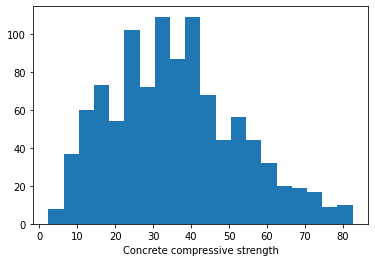

In [18]:
plt.figure()
plt.hist(output_data, bins = 20); plt.xlabel('Concrete compressive strength')
plt.show()

## ได้เวลา tune โมเดล 
ปรับค่า $\alpha$ สำหรับ Ridge และ LASSO

ใช้ [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) เพื่ออำนวยความสะดวก สามารถรับการแบ่ง k-fold cross-validation เข้าไปได้ด้วย

สามารถใส่การวัดผลได้หลายแบบ และสามารถสั่งให้เทรนโมเดลที่ได้ผลดีที่สุดออกมาเลย

In [19]:
parameters = {'alpha':[0.0001, 0.001, 0.01, 1, 10, 100]}

grid_lasso = GridSearchCV(estimator = base_lasso, param_grid = parameters, 
                          scoring = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
                          refit = 'neg_mean_absolute_error', cv = cv_splitter)

grid_lasso.fit(X_train_std, y_train_std)

GridSearchCV(cv=KFold(n_splits=5, random_state=4649, shuffle=True),
             estimator=Lasso(random_state=4649),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 1, 10, 100]},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

### ดูผลภาพรวมของการ tune

In [20]:
grid_lasso_result = pd.DataFrame.from_dict(grid_lasso.cv_results_)
grid_lasso_result.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,0.003477,0.001213,0.001958,0.000536,0.0001,{'alpha': 0.0001},-0.518673,-0.449985,-0.576159,-0.477985,...,0.042865,1,-1.556710,-1.768678,-2.690993,-1.105463,-1.428947,-1.710158,0.535489,5
1,0.002584,0.000028,0.001682,0.000011,0.001,{'alpha': 0.001},-0.519464,-0.450522,-0.576730,-0.479208,...,0.042744,2,-1.555526,-1.763834,-2.702313,-1.105312,-1.426787,-1.710754,0.539870,6


เรียงลำดับตามคะแนน MAE และเลือกแสดงเฉพาะบางคอลัมน์

In [21]:
grid_lasso_result = grid_lasso_result.sort_values('rank_test_neg_mean_absolute_error')
grid_lasso_result[['params', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error']].head()

,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error
0,{'alpha': 0.0001},-0.508719,0.042865
1,{'alpha': 0.001},-0.509276,0.042744
2,{'alpha': 0.01},-0.512125,0.043499
3,{'alpha': 1},-0.808461,0.044536
4,{'alpha': 10},-0.808461,0.044536


### เปรียบเทียบผลการทำงานหลังจากที่ tune แล้ว
บน cross-validation และ test set

In [22]:
print('Cross-validated LASSO MAE:', -grid_lasso_result['mean_test_neg_mean_absolute_error'].iloc[0])

grid_lasso_pred_test = grid_lasso.predict(X_test_std)
print('Test LASSO MAE:', mean_absolute_error(y_test_std, grid_lasso_pred_test))

Cross-validated LASSO MAE: 0.5087188781070362
Test LASSO MAE: 0.43781527902015294


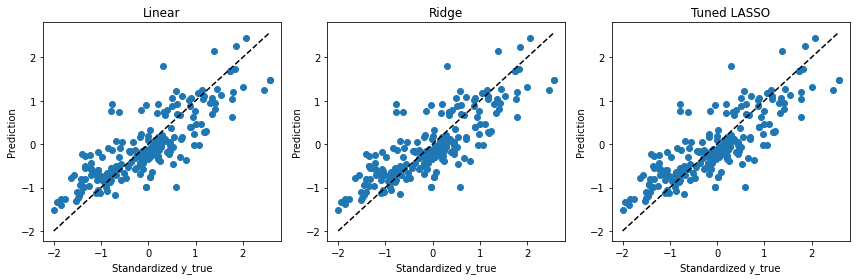

In [23]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 3, 1)
plt.scatter(y_test_std, base_linear_pred_test); plt.xlabel('Standardized y_true'); plt.ylabel('Prediction'); plt.title('Linear')
plt.plot([y_test_std.min(), y_test_std.max()], [y_test_std.min(), y_test_std.max()], '--k')

plt.subplot(1, 3, 2)
plt.scatter(y_test_std, base_ridge_pred_test); plt.xlabel('Standardized y_true'); plt.ylabel('Prediction'); plt.title('Ridge')
plt.plot([y_test_std.min(), y_test_std.max()], [y_test_std.min(), y_test_std.max()], '--k')

plt.subplot(1, 3, 3)
plt.scatter(y_test_std, grid_lasso_pred_test); plt.xlabel('Standardized y_true'); plt.ylabel('Prediction'); plt.title('Tuned LASSO')
plt.plot([y_test_std.min(), y_test_std.max()], [y_test_std.min(), y_test_std.max()], '--k')

plt.tight_layout()
plt.show()

## ลองใช้ Support Vector Machine กับ radial basis kernel
ต้อง tune สองตัวแปรหลักคือ *C* ซึ่งกำกับ regularization และ *$\epsilon$* ซึ่งกำกับขนาดของ error ที่ยอมรับได้

เพิ่ม argument *n_jobs* เพื่อใช้หลาย CPU ในการเร่งความเร็ว

In [24]:
rbf_svr = SVR(kernel = 'rbf')
parameters = {'epsilon': np.arange(0, 0.21, 0.05), 'C': np.power(10, np.linspace(-3, 3, 5))}

grid_rbf_svr = GridSearchCV(estimator = rbf_svr, param_grid = parameters, 
                            scoring = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
                            refit = 'neg_mean_absolute_error', cv = cv_splitter, n_jobs = 4)

grid_rbf_svr.fit(X_train_std, y_train_std.reshape([-1, ])) ## SVR อยากให้ output เป็น 1D array

GridSearchCV(cv=KFold(n_splits=5, random_state=4649, shuffle=True),
             estimator=SVR(), n_jobs=4,
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'epsilon': array([0.  , 0.05, 0.1 , 0.15, 0.2 ])},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

MAE ดีขึ้นบน cross-validation

In [25]:
grid_rbf_svr_result = pd.DataFrame.from_dict(grid_rbf_svr.cv_results_)
grid_rbf_svr_result = grid_rbf_svr_result.sort_values('rank_test_neg_mean_absolute_error')
grid_rbf_svr_result[['params', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error']].head(5)

,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error
16,"{'C': 31.622776601683793, 'epsilon': 0.05}",-0.249800,0.015711
15,"{'C': 31.622776601683793, 'epsilon': 0.0}",-0.250907,0.015308
17,"{'C': 31.622776601683793, 'epsilon': 0.1}",-0.252415,0.017523
18,"{'C': 31.622776601683793, 'epsilon': 0.1500000...",-0.255480,0.016183
19,"{'C': 31.622776601683793, 'epsilon': 0.2}",-0.256850,0.014925


### ผลบน test set

In [26]:
grid_rbf_svr_pred_test = grid_rbf_svr.predict(X_test_std)
print('Test RBF SVM MAE:', mean_absolute_error(y_test_std, grid_rbf_svr_pred_test))

Test RBF SVM MAE: 0.22776192543877458


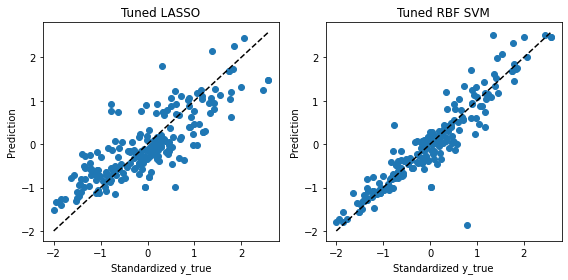

In [27]:
plt.figure(figsize = (8, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test_std, grid_lasso_pred_test); plt.xlabel('Standardized y_true'); plt.ylabel('Prediction'); plt.title('Tuned LASSO')
plt.plot([y_test_std.min(), y_test_std.max()], [y_test_std.min(), y_test_std.max()], '--k')

plt.subplot(1, 2, 2)
plt.scatter(y_test_std, grid_rbf_svr_pred_test); plt.xlabel('Standardized y_true'); plt.ylabel('Prediction'); plt.title('Tuned RBF SVM')
plt.plot([y_test_std.min(), y_test_std.max()], [y_test_std.min(), y_test_std.max()], '--k')

plt.tight_layout()
plt.show()

# ข้อมูลชุดที่ 2 ราคาขายบ้าน
อย่าลืมเปลี่ยนตำแหน่งของไฟล์ HousePrices.csv ให้เป็นไปตามตำแหน่งที่เราวางใน Google Drive ของเราเอง

ข้อมูลชุดนี้เกี่ยวกับราคาขายบ้าน ซึ่งขึ้นอยู่กับขนาดและลักษณะต่าง ๆ โดยเพื่อความสะดวก เราจะใช้เฉพาะตัวแปรที่เป็นตัวเลขจำนวน 11 ตัวแปร

In [28]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/HousePrices.csv', index_col = None) ## ข้อมูลนี้ไม่มี row index
numerical_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF', 'GrLivArea', 'GarageArea',
                      'WoodDeckSF', 'OpenPorchSF', 'SalePrice']
data = data[numerical_features]
data.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
0,65.0,8450,196.0,706,150,856,1710,548,0,61,208500
1,80.0,9600,0.0,978,284,1262,1262,460,298,0,181500
2,68.0,11250,162.0,486,434,920,1786,608,0,42,223500
3,60.0,9550,0.0,216,540,961,1717,642,0,35,140000
4,84.0,14260,350.0,655,490,1145,2198,836,192,84,250000


## ตรวจจับและเติม missing value

In [29]:
missing_count = pd.isna(data).sum()
print('Total data size:', data.shape[0])
print('Missing data:', missing_count[missing_count > 0])

Total data size: 1456
Missing data: LotFrontage    259
dtype: int64


In [30]:
imputed_data = data.copy()
m = imputed_data['LotFrontage'].mean()
imputed_data['LotFrontage'] = imputed_data['LotFrontage'].fillna(int(m))

แบ่งเป็น input / output

In [31]:
input_data = imputed_data.iloc[:, :-1]
output_data = imputed_data.iloc[:, -1]

## คำนวณ correlation

In [32]:
correlations = pd.DataFrame(0, index = input_data.columns, columns = ['Pearson', 'Spearman', 'Kendall'])

for x in input_data.columns:
    correlations.loc[x, :] = [pearsonr(input_data[x], output_data)[0], ## ฟังก์ชันเหล่านี้จะคืนค่า correlation และ p-value 
                              spearmanr(input_data[x], output_data)[0],
                              kendalltau(input_data[x], output_data)[0]]

correlations.head(10)

,Pearson,Spearman,Kendall
LotFrontage,0.338149,0.373547,0.265657
LotArea,0.269866,0.454983,0.313076
MasVnrArea,0.473650,0.416597,0.317771
BsmtFinSF1,0.395923,0.299285,0.218968
BsmtUnfSF,0.220678,0.184640,0.127113
1stFlrSF,0.625235,0.574478,0.410764
GrLivArea,0.720516,0.731238,0.543864
GarageArea,0.636964,0.649030,0.478032
WoodDeckSF,0.322538,0.351925,0.259093
OpenPorchSF,0.330361,0.477450,0.350553


## แบ่งข้อมูลเป็น train-test และ cross-validation

In [33]:
X_train, X_test, y_train, y_test = train_test_split(imputed_data.iloc[:, :-1], imputed_data.iloc[:, -1], test_size = 0.2, random_state = 4649)

print('train data shape:', X_train.shape)
print('test data shape:', X_test.shape)

train data shape: (1164, 10)
test data shape: (292, 10)


In [34]:
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train.values.reshape([-1, 1])) ## ฟังก์ชันบางตัวจะจุกจิกนิดหน่อยในเรื่อง 1D หรือ 2D array

X_train_std = pd.DataFrame(X_scaler.transform(X_train), index = X_train.index, columns = X_train.columns) ## เพื่อความสะดวกในตอนวิเคราะห์ผลหลังทำโมเดล
X_test_std = pd.DataFrame(X_scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

y_train_std = y_scaler.transform(y_train.values.reshape([-1, 1]))
y_test_std = y_scaler.transform(y_test.values.reshape([-1, 1]))

In [35]:
cv_splitter = KFold(n_splits = 5, shuffle = True, random_state = 4649)

## เทรนโมเดลด้วย LASSO และ RBF SVM
สังเกตว่า RBF SVM จะใช้เวลาเทรนนานขึ้นมา ตามปริมาณข้อมูล

In [36]:
lasso_params = {'alpha': [1e-4, 1e-3, 0.01, 0.1, 1, 10]}
grid_lasso = GridSearchCV(estimator = base_lasso, param_grid = lasso_params, 
                          scoring = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
                          refit = 'neg_mean_absolute_error', cv = cv_splitter)

grid_lasso.fit(X_train_std, y_train_std)

rbf_svm_params = {'epsilon': np.arange(0, 0.21, 0.05), 'C': np.power(10, np.linspace(-3, 3, 5))}
grid_rbf_svr = GridSearchCV(estimator = rbf_svr, param_grid = rbf_svm_params, 
                            scoring = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
                            refit = 'neg_mean_absolute_error', cv = cv_splitter, n_jobs = 4)

grid_rbf_svr.fit(X_train_std, y_train_std.reshape([-1, ]))

GridSearchCV(cv=KFold(n_splits=5, random_state=4649, shuffle=True),
             estimator=SVR(), n_jobs=4,
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'epsilon': array([0.  , 0.05, 0.1 , 0.15, 0.2 ])},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

### ผลของ LASSO

In [37]:
grid_lasso_result = pd.DataFrame.from_dict(grid_lasso.cv_results_)
grid_lasso_result = grid_lasso_result.sort_values('rank_test_neg_mean_absolute_error')
grid_lasso_result[['params', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error']].head(5)

,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error
2,{'alpha': 0.01},-0.348824,0.023050
1,{'alpha': 0.001},-0.349863,0.022957
0,{'alpha': 0.0001},-0.350095,0.022936
3,{'alpha': 0.1},-0.378600,0.029744
4,{'alpha': 1},-0.741870,0.038814


### ผลของ RBF SVM

In [38]:
grid_rbf_svr_result = pd.DataFrame.from_dict(grid_rbf_svr.cv_results_)
grid_rbf_svr_result = grid_rbf_svr_result.sort_values('rank_test_neg_mean_absolute_error')
grid_rbf_svr_result[['params', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error']].head(5)

,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error
12,"{'C': 1.0, 'epsilon': 0.1}",-0.321884,0.025337
13,"{'C': 1.0, 'epsilon': 0.15000000000000002}",-0.322806,0.024922
11,"{'C': 1.0, 'epsilon': 0.05}",-0.324270,0.025056
14,"{'C': 1.0, 'epsilon': 0.2}",-0.325986,0.023516
10,"{'C': 1.0, 'epsilon': 0.0}",-0.326579,0.025635


## แสดงผลการทำนายบน test set

In [39]:
grid_lasso_pred_test = grid_lasso.predict(X_test_std)
grid_rbf_svr_pred_test = grid_rbf_svr.predict(X_test_std)

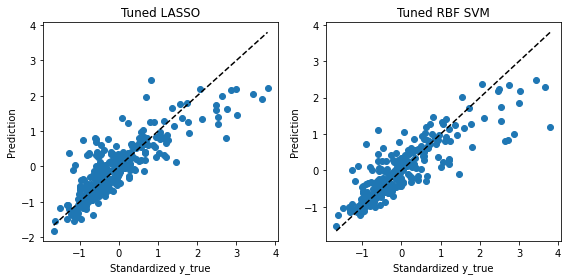

In [40]:
plt.figure(figsize = (8, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test_std, grid_lasso_pred_test); plt.xlabel('Standardized y_true'); plt.ylabel('Prediction'); plt.title('Tuned LASSO')
plt.plot([y_test_std.min(), y_test_std.max()], [y_test_std.min(), y_test_std.max()], '--k')

plt.subplot(1, 2, 2)
plt.scatter(y_test_std, grid_rbf_svr_pred_test); plt.xlabel('Standardized y_true'); plt.ylabel('Prediction'); plt.title('Tuned RBF SVM')
plt.plot([y_test_std.min(), y_test_std.max()], [y_test_std.min(), y_test_std.max()], '--k')

plt.tight_layout()
plt.show()

## ดูสัมประสิทธ์ของโมเดล LASSO เทียบกับ correlation ที่คำนวณไว้ 

In [41]:
lasso_coefficients = grid_lasso.best_estimator_.coef_
lasso_coefficients = pd.DataFrame(lasso_coefficients, index = input_data.columns, columns = ['LASSO coefficient'])

pd.concat([lasso_coefficients, correlations], axis = 1).head(20)

,LASSO coefficient,Pearson,Spearman,Kendall
LotFrontage,0.021069,0.338149,0.373547,0.265657
LotArea,0.037054,0.269866,0.454983,0.313076
MasVnrArea,0.116549,0.473650,0.416597,0.317771
BsmtFinSF1,0.336151,0.395923,0.299285,0.218968
BsmtUnfSF,0.213153,0.220678,0.184640,0.127113
1stFlrSF,0.014376,0.625235,0.574478,0.410764
GrLivArea,0.421389,0.720516,0.731238,0.543864
GarageArea,0.214996,0.636964,0.649030,0.478032
WoodDeckSF,0.058800,0.322538,0.351925,0.259093
OpenPorchSF,0.062311,0.330361,0.477450,0.350553


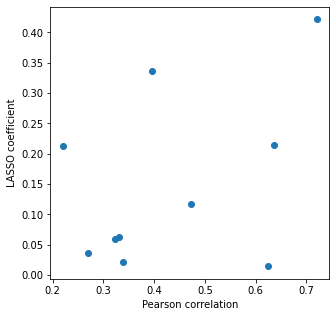

In [42]:
plt.figure(figsize = (5, 5))
plt.scatter(correlations['Pearson'], lasso_coefficients)
plt.xlabel('Pearson correlation'); plt.ylabel('LASSO coefficient')
plt.show()

ตัวแปรบางตัวมี correlation กับผลเฉลย แต่โมเดล LASSO ไม่สนใจ เช่น **1stFlrSF**

เมื่อเราคำนวณ correlation ระหว่างตัวแปรด้วยกันเอง จะพบว่า **1stFlrSF** มีความสัมพันธ์กับ **GrLivArea** และ **GarageArea** สูง

LASSO อาศัยข้อมูลผ่านตัวแปร **GrLivArea** และ **GarageArea** ไปแล้ว จึงไม่ให้ความสำคัญกับ **1stFlrSF** 

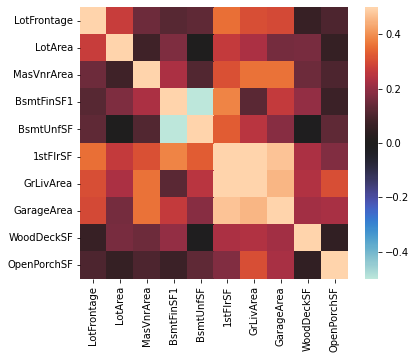

In [43]:
corr_mat = np.corrcoef(input_data.T)
corr_mat = pd.DataFrame(corr_mat, index = input_data.columns, columns = input_data.columns)

plt.figure(figsize = (6, 5))
sns.heatmap(corr_mat, center = 0, vmin = -0.5, vmax = 0.5)
plt.show()

# ข้อมูลชุดที่ 3 ทำนายกลุ่มลูกค้า
เป็นข้อมูลการทำนายกลุ่มลูกค้า (Customer segmentation) โดยอาศัยข้อมูลส่วนตัว เช่น เพศ อายุ สถานะสมรส อาชีพ เป็นต้น

In [44]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/CustomerSegment.csv', index_col = 0)
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
ID,,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


## ตรวจจับและเติม missing value

In [45]:
missing_count = pd.isna(data).sum()
print('Total data size:', data.shape[0])
print('Missing data:', missing_count[missing_count > 0])

Total data size: 8068
Missing data: Ever_Married       140
Graduated           78
Profession         124
Work_Experience    829
Family_Size        335
Var_1               76
dtype: int64


### ทิ้งตัวแปรและข้อมูลที่มีปัญหา
ทิ้งตัวแปร Work_Experience เพราะข้อมูลหายเป็นปริมาณมาก

ทิ้งข้อมูลที่ไม่มี Profession เพราะเติมยาก

In [46]:
print('Data size before dropping:', data.shape)

data = data.drop('Work_Experience', axis = 1)
data = data.loc[~pd.isna(data['Profession']), :]

print('Data size after dropping:', data.shape)

Data size before dropping: (8068, 10)
Data size after dropping: (7944, 9)


### แยกตัวแปร input กับ output ออกจากกัน

In [47]:
input_data = data.iloc[:, :-1]
output_data = data.iloc[:, -1]

### เติมค่าตัวแปรอื่นด้วย mode หรือ mean ตามชนิดของตัวแปร

In [48]:
categorical_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

imputed_data = input_data.copy()
imputed_data[categorical_features] = imputed_data[categorical_features].fillna(imputed_data[categorical_features].mode().iloc[0])
imputed_data['Family_Size'] = imputed_data['Family_Size'].fillna(imputed_data['Family_Size'].mean()).astype(int) ## ปรับจำนวนสมาชิกในครอบครัวเป็นจำนวนเต็ม

## แปลงข้อมูล categorical ให้เป็นตัวเลข

In [49]:
for f in categorical_features:
    print(f, pd.unique(imputed_data[f]))

formatted_data = imputed_data.copy()

Gender ['Male' 'Female']
Ever_Married ['No' 'Yes']
Graduated ['No' 'Yes']
Profession ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing']
Spending_Score ['Low' 'Average' 'High']
Var_1 ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' 'Cat_5']


ตัวแปร binary

In [50]:
formatted_data['Gender'] = (imputed_data['Gender'] == 'Male').astype(int)
formatted_data['Ever_Married'] = (imputed_data['Ever_Married'] == 'Yes').astype(int)
formatted_data['Graduated'] = (imputed_data['Graduated'] == 'Yes').astype(int)

ตัวแปรที่มีหลาย category จะใช้ [pandas.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)

In [51]:
dummies = pd.get_dummies(formatted_data['Var_1'], prefix = 'Var_1', prefix_sep = ':')
formatted_data = pd.concat([formatted_data.drop('Var_1', axis = 1), dummies], axis = 1)

dummies = pd.get_dummies(formatted_data['Profession'], prefix = 'Profession', prefix_sep = ':')
formatted_data = pd.concat([formatted_data.drop('Profession', axis = 1), dummies], axis = 1)

formatted_data.head(2)

,Gender,Ever_Married,Age,Graduated,Spending_Score,Family_Size,Var_1:Cat_1,Var_1:Cat_2,Var_1:Cat_3,Var_1:Cat_4,...,Var_1:Cat_7,Profession:Artist,Profession:Doctor,Profession:Engineer,Profession:Entertainment,Profession:Executive,Profession:Healthcare,Profession:Homemaker,Profession:Lawyer,Profession:Marketing
ID,,,,,,,,,,,,,,,,,,,,,
462809,1,0,22,0,Low,4,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
462643,0,1,38,1,Average,3,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


### ตัวแปรที่มีลำดับจะต้องแปลงค่าแบบเป็นขั้น

สำหรับกรณี Spending_Score มีค่าที่เป็นไปได้คือ Low, Average, High ดังนั้นเราอาจจะแทนค่าเป็น 0, 1, 2 ตามลำดับ

หรืออาจจะตั้งตัวแปรใหม่เพื่อสะท้อนความแตกต่างของ Average เทียบกับ Low และค High เทียบกับ Average ซึ่งจะทำให้โมเดลสามารถเรียนรู้ขนาด (effect size) ที่การเปลี่ยนขั้นของค่าตัวแปรมีผลต่อคำทำนายได้

| ระดับเดิม | Low ไป Average | Average ไป High |
| --- | --- | --- |
| Low | 0 | 0 | 
| Average | 1 | 0 | 
| High | 1 | 1 | 

In [52]:
formatted_data['Spending_Score'] = formatted_data['Spending_Score'].map({'Low':0, 'Average':1, 'High':2})
formatted_data.head(2)

,Gender,Ever_Married,Age,Graduated,Spending_Score,Family_Size,Var_1:Cat_1,Var_1:Cat_2,Var_1:Cat_3,Var_1:Cat_4,...,Var_1:Cat_7,Profession:Artist,Profession:Doctor,Profession:Engineer,Profession:Entertainment,Profession:Executive,Profession:Healthcare,Profession:Homemaker,Profession:Lawyer,Profession:Marketing
ID,,,,,,,,,,,,,,,,,,,,,
462809,1,0,22,0,0,4,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
462643,0,1,38,1,1,3,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


## แบ่งข้อมูลเป็น train-test และ cross-validation
กำกับการแบ่งตามสัดส่วนคลาสของคำตอบ (stratification)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(formatted_data, output_data, test_size = 0.2,
                                                    stratify = output_data, random_state = 4649)

ordered_class = sorted(pd.unique(output_data))
y_class_table = pd.concat([y_train.value_counts().loc[ordered_class], 
                           y_test.value_counts().loc[ordered_class]], axis = 1)
y_class_table.columns = ['Train', 'Test']
y_class_table.head(5)

,Train,Test
A,1551,388
B,1469,367
C,1562,390
D,1773,444


In [54]:
X_scaler = StandardScaler().fit(X_train)

X_train_std = pd.DataFrame(X_scaler.transform(X_train), index = X_train.index, columns = X_train.columns) ## เพื่อความสะดวกในตอนวิเคราะห์ผลหลังทำโมเดล
X_test_std = pd.DataFrame(X_scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

In [55]:
cv_splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4649)

## เทรนโมเดล Logistic Regression กับ RBF SVM

In [56]:
base_logistic = LogisticRegression(random_state = 4649, solver = 'liblinear') ## ตั้งค่าตัว optimizer เป็น liblinear ซึ่งรองรับ L1-regularization
rbf_svm = SVC(kernel = 'rbf')

In [57]:
logistic_params = {'C': [1e-4, 1e-3, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
grid_logistic = GridSearchCV(estimator = base_logistic, param_grid = logistic_params, 
                             scoring = ['accuracy'], refit = 'accuracy', cv = cv_splitter)

grid_logistic.fit(X_train_std, y_train)

rbf_svm_params = {'C': np.power(10, np.linspace(-3, 3, 5))}
grid_rbf_svm = GridSearchCV(estimator = rbf_svm, param_grid = rbf_svm_params, 
                            scoring = ['accuracy'], refit = 'accuracy', cv = cv_splitter, n_jobs = 4)

grid_rbf_svm.fit(X_train_std, y_train.to_numpy().reshape([-1, ])) ## ต้องแปลงเป็น 1 มิติ

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4649, shuffle=True),
             estimator=SVC(), n_jobs=4,
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03])},
             refit='accuracy', scoring=['accuracy'])

### ผลของ Logistic Regression

In [58]:
grid_logistic_result = pd.DataFrame.from_dict(grid_logistic.cv_results_)
grid_logistic_result = grid_logistic_result.sort_values('rank_test_accuracy')
grid_logistic_result[['params', 'mean_test_accuracy', 'std_test_accuracy']].head(5)

,params,mean_test_accuracy,std_test_accuracy
8,"{'C': 1, 'penalty': 'l1'}",0.502124,0.009045
6,"{'C': 0.1, 'penalty': 'l1'}",0.501810,0.007337
10,"{'C': 10, 'penalty': 'l1'}",0.501652,0.009960
11,"{'C': 10, 'penalty': 'l2'}",0.501652,0.009960
9,"{'C': 1, 'penalty': 'l2'}",0.501338,0.009845


### ผลของ RBF SVM

In [59]:
grid_rbf_svm_result = pd.DataFrame.from_dict(grid_rbf_svm.cv_results_)
grid_rbf_svm_result = grid_rbf_svm_result.sort_values('rank_test_accuracy')
grid_rbf_svm_result[['params', 'mean_test_accuracy', 'std_test_accuracy']].head(5)

,params,mean_test_accuracy,std_test_accuracy
2,{'C': 1.0},0.508891,0.008198
3,{'C': 31.622776601683793},0.500708,0.007686
4,{'C': 1000.0},0.480094,0.010838
1,{'C': 0.03162277660168379},0.476947,0.017233
0,{'C': 0.001},0.278993,0.000385


## วิเคราะห์ความผิดพลาดของโมเดล Logistic Regression
รายงานผลภาพรวมด้วย Classification report

In [63]:
grid_logistic_pred_test = grid_logistic.predict(X_test_std)
print(classification_report(y_test, grid_logistic_pred_test))

              precision    recall  f1-score   support

           A       0.42      0.49      0.45       388
           B       0.38      0.12      0.18       367
           C       0.48      0.67      0.56       390
           D       0.65      0.69      0.67       444

    accuracy                           0.50      1589
   macro avg       0.48      0.49      0.46      1589
weighted avg       0.49      0.50      0.47      1589



ดูรายละเอียดความผิดพลาดระหว่างกลุ่มด้วย Confusion matrix

In [64]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, grid_logistic_pred_test),
                        index = ordered_class, columns = ['Predicted ' + x for x in ordered_class])
conf_mat.head(5)

,Predicted A,Predicted B,Predicted C,Predicted D
A,189,33,92,74
B,117,43,164,43
C,53,24,261,52
D,93,12,31,308


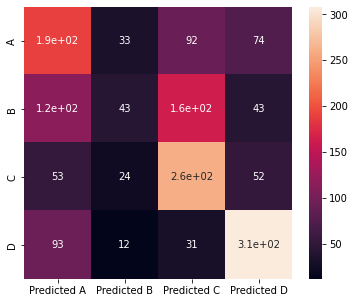

In [65]:
plt.figure(figsize = (6, 5))
sns.heatmap(conf_mat, annot = True)
plt.show()

## วิเคราะห์ความผิดพลาดของโมเดล RBF SVM
รายงานผลภาพรวมด้วย Classification report

In [60]:
grid_rbf_svm_pred_test = grid_rbf_svm.predict(X_test_std)
print(classification_report(y_test, grid_rbf_svm_pred_test))

              precision    recall  f1-score   support

           A       0.45      0.51      0.48       388
           B       0.39      0.34      0.36       367
           C       0.58      0.52      0.55       390
           D       0.64      0.69      0.67       444

    accuracy                           0.52      1589
   macro avg       0.52      0.52      0.51      1589
weighted avg       0.52      0.52      0.52      1589



In [61]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, grid_rbf_svm_pred_test),
                        index = ordered_class, columns = ['Predicted ' + x for x in ordered_class])
conf_mat.head(5)

,Predicted A,Predicted B,Predicted C,Predicted D
A,198,87,30,73
B,90,125,107,45
C,48,86,204,52
D,100,25,12,307


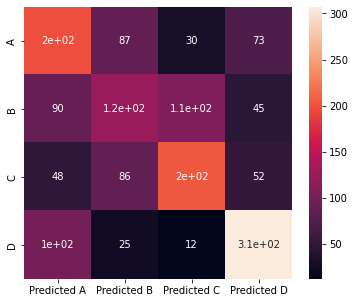

In [62]:
plt.figure(figsize = (6, 5))
sns.heatmap(conf_mat, annot = True)
plt.show()